In [11]:
from PINNs import PINN, Geometry, Physics, NetworkTrainer, Visualizer, ProblemDomain
import torch
import matplotlib.pyplot as plt

In [12]:
circle = Geometry.circle(0.2, 0.2, 0.05)
area_big = Geometry.rectangle([0,1.1],[0,0.41])
area = area_big - circle

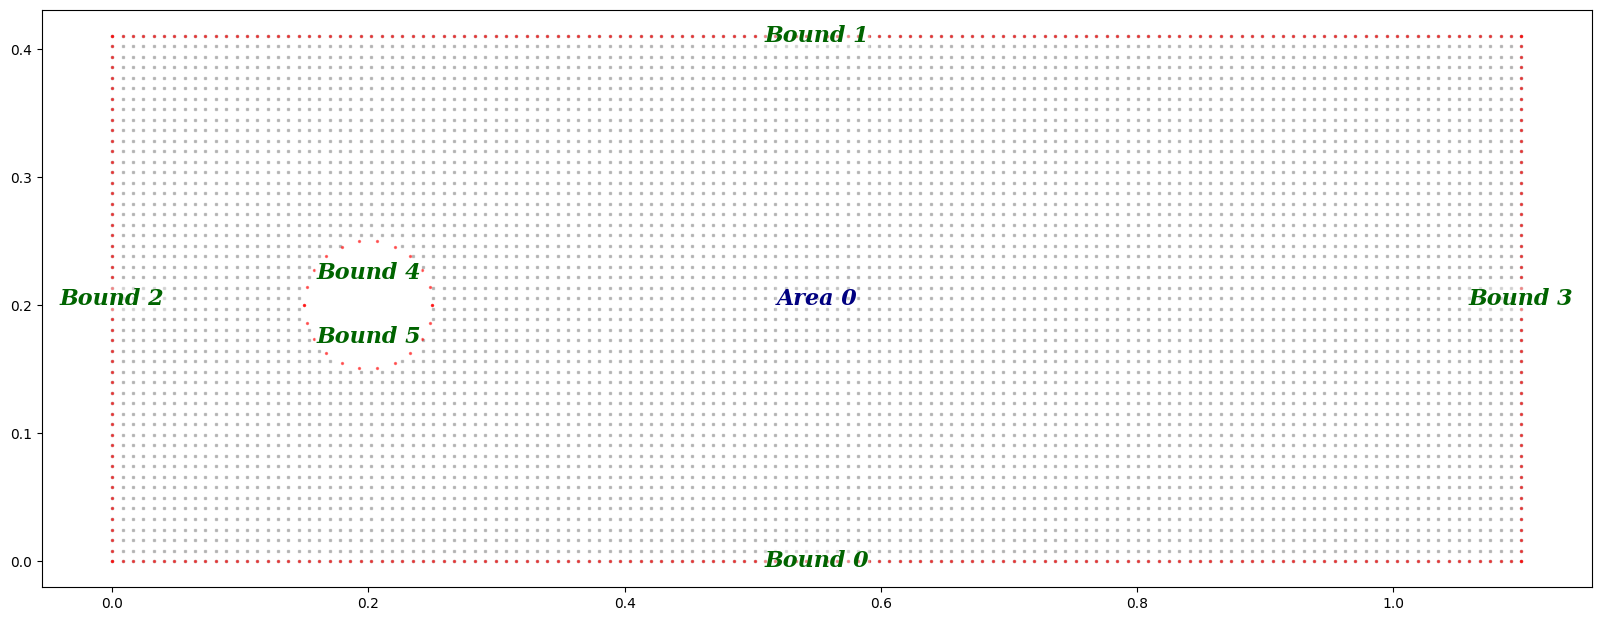

In [13]:
domain = ProblemDomain(area.bound_list + circle.bound_list, [area])
domain.show_setup()

## Define Physics

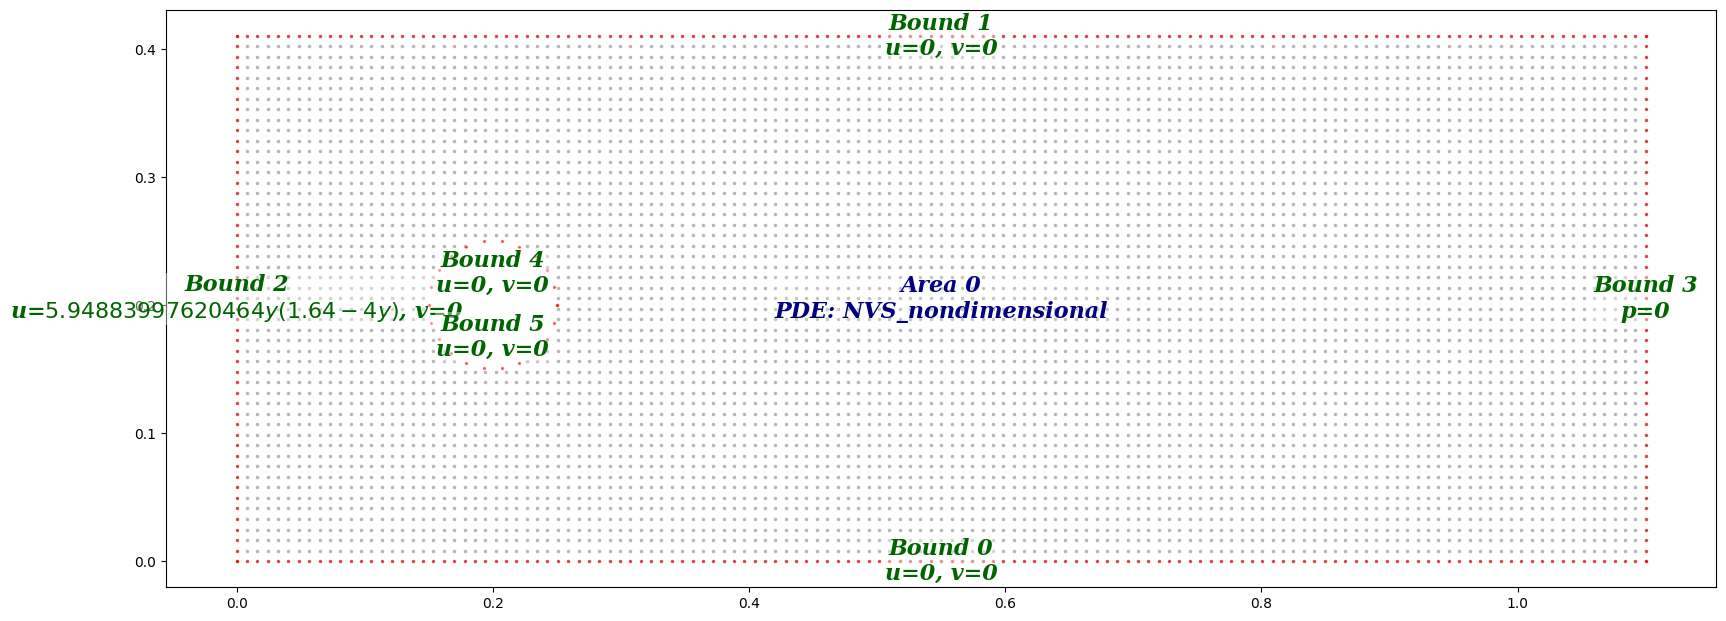

In [14]:
domain.bound_list[0].define_bc({'u':0,'v':0})
domain.bound_list[1].define_bc({'u':0,'v':0})
domain.bound_list[2].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[3].define_bc({'p':0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(Physics.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


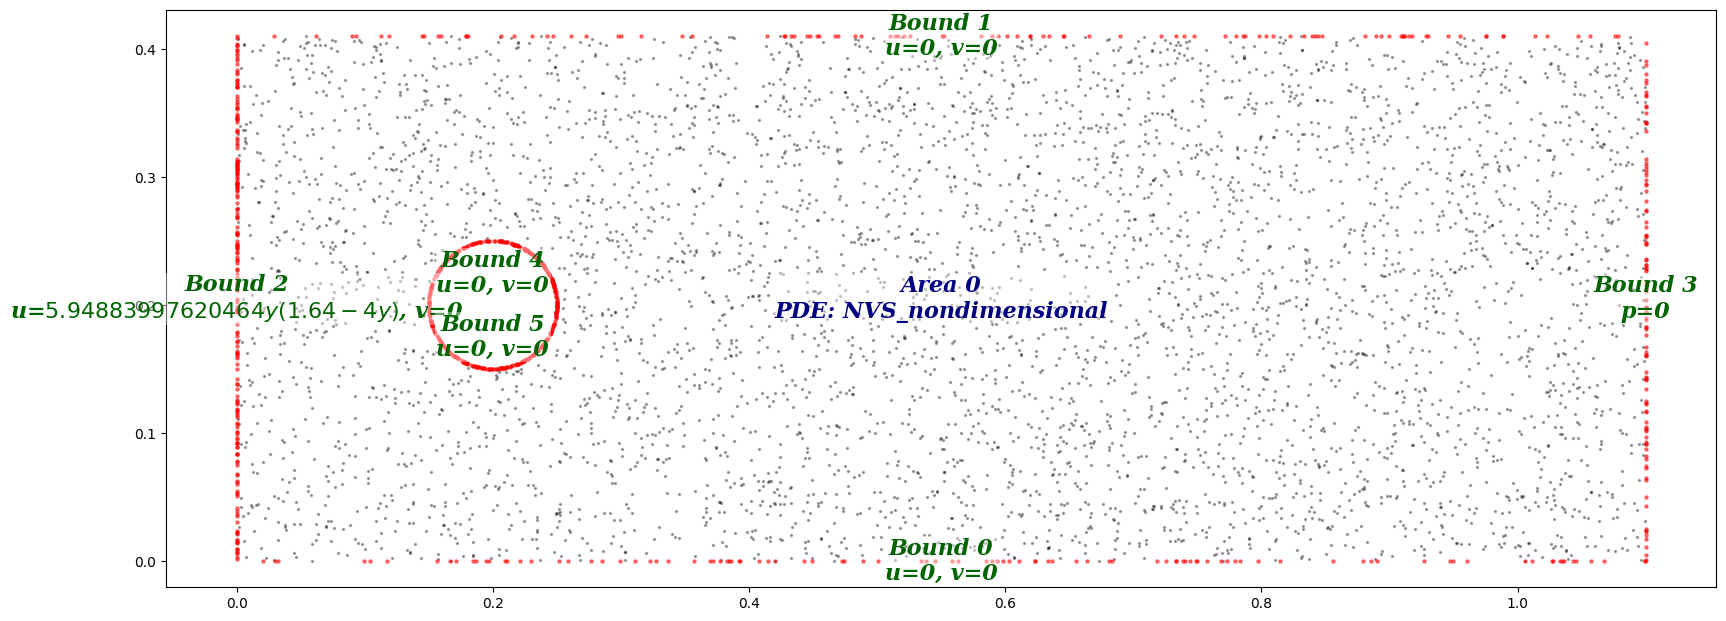

In [15]:
domain.sampling_random_r([100, 100, 200, 100, 200, 200], [5000], device='cuda')
domain.show_coordinates()

In [16]:
model0 = PINN(width=40, length=8)
loss_fn = torch.nn.MSELoss()
n = 0

In [17]:
# Define the loss calculation function
def calc_loss(model):
    global n
    # Re-sample the collocation points
    # if n % 50 == 0 or n == 0:
    #     domain.sampling_random_r([800, 800, 400, 200], [1000], device='cuda')
    n += 1
    if n%1000==0:
        domain.sampling_RAR([40, 40, 160, 40, 80, 80], [2000], model, [200, 200, 400, 200, 400, 400], [20000], device='cuda')
    
    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        if i == 2:
            bc_loss += 2*bc.calc_loss(model, loss_fn)
        else:
            bc_loss += bc.calc_loss(model, loss_fn) #lambda pred, true: ((pred - true)**2/true).mean())

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model, loss_fn)

    # Total Loss
    total_loss = 3*bc_loss + pde_loss

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [18]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.0001,
    epochs=10000,
    print_every=100,
    thereshold_loss=0.01,
    device='cuda'
)

epoch 1, total_loss: 2.62383, bc_loss: 0.87460, pde_loss: 0.00002
epoch 101, total_loss: 1.98824, bc_loss: 0.65237, pde_loss: 0.03112
epoch 201, total_loss: 1.55201, bc_loss: 0.43801, pde_loss: 0.23799
epoch 301, total_loss: 1.31395, bc_loss: 0.34483, pde_loss: 0.27945
epoch 401, total_loss: 1.15241, bc_loss: 0.32068, pde_loss: 0.19037
epoch 501, total_loss: 1.09294, bc_loss: 0.30359, pde_loss: 0.18217
epoch 601, total_loss: 1.03124, bc_loss: 0.27836, pde_loss: 0.19618
epoch 701, total_loss: 0.88925, bc_loss: 0.22150, pde_loss: 0.22475
epoch 801, total_loss: 0.73491, bc_loss: 0.17512, pde_loss: 0.20954
epoch 901, total_loss: 0.65345, bc_loss: 0.15391, pde_loss: 0.19170
epoch 1001, total_loss: 1.15829, bc_loss: 0.25444, pde_loss: 0.39497
epoch 1101, total_loss: 0.98457, bc_loss: 0.26772, pde_loss: 0.18140
epoch 1201, total_loss: 0.94469, bc_loss: 0.25476, pde_loss: 0.18043
epoch 1301, total_loss: 0.90802, bc_loss: 0.24271, pde_loss: 0.17990
epoch 1401, total_loss: 0.86664, bc_loss: 0.22

In [19]:
# Train the model
model2 = NetworkTrainer.train_lbfgs(
    model=model1,
    calc_loss=calc_loss,
    epochs=1000,
    print_every=50,
    thereshold_loss=0.002,
    device='cuda'
)

epoch 10001, total_loss: 0.02269, bc_loss: 0.00219, pde_loss: 0.01611
epoch 10051, total_loss: 0.01196, bc_loss: 0.00108, pde_loss: 0.00871
epoch 10101, total_loss: 0.00879, bc_loss: 0.00090, pde_loss: 0.00610
epoch 10151, total_loss: 0.00648, bc_loss: 0.00068, pde_loss: 0.00445
epoch 10201, total_loss: 0.00525, bc_loss: 0.00060, pde_loss: 0.00344
epoch 10251, total_loss: 0.00419, bc_loss: 0.00054, pde_loss: 0.00257
epoch 10301, total_loss: 0.00364, bc_loss: 0.00051, pde_loss: 0.00210
epoch 10351, total_loss: 0.00324, bc_loss: 0.00046, pde_loss: 0.00187
epoch 10401, total_loss: 0.00274, bc_loss: 0.00039, pde_loss: 0.00155
epoch 10451, total_loss: 0.00251, bc_loss: 0.00036, pde_loss: 0.00144
epoch 10501, total_loss: 0.00225, bc_loss: 0.00032, pde_loss: 0.00130
epoch 10551, total_loss: 0.00210, bc_loss: 0.00029, pde_loss: 0.00122
Training stopped at epoch 569 as total loss reached the threshold of 0.002.


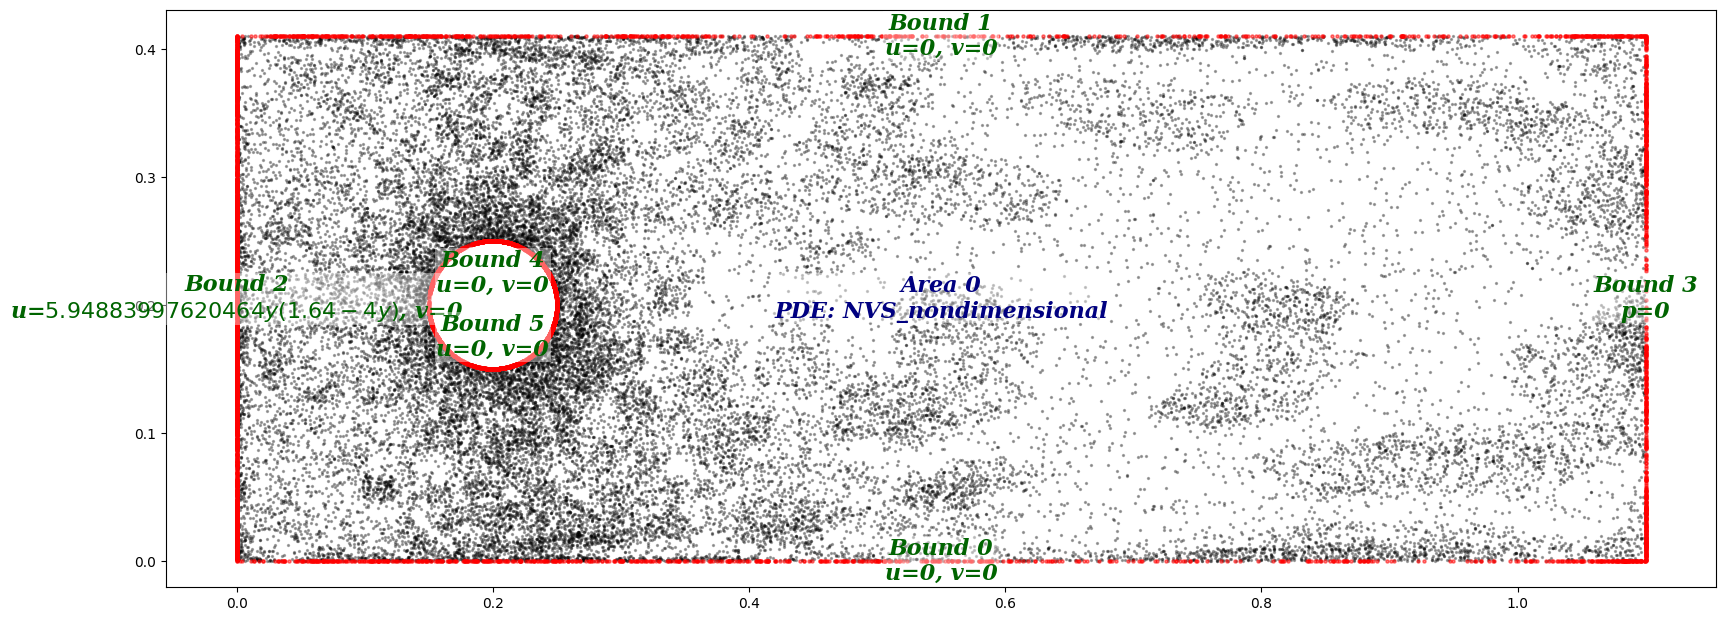

number of bound : 6
        ['0: 740', '1: 740', '2: 2760', '3: 740', '4: 1480', '5: 1480']
        , number of area : 1
        ['0: 36894']


In [20]:
domain.show_coordinates()
print(domain)

In [52]:
# Create visualization object
area_visual = Visualizer(model2, domain.area_list[0])
area_visual.sampling_area([1000,400])
keyword = area_visual.preprocess()

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'u_x', 'v_x', 'p_x', 'u_y', 'v_y', 'p_y', 'u_xx', 'v_xx', 'u_yy', 'v_yy', 'PDE residual', 'total_loss', 'bc_loss', 'pde_loss')


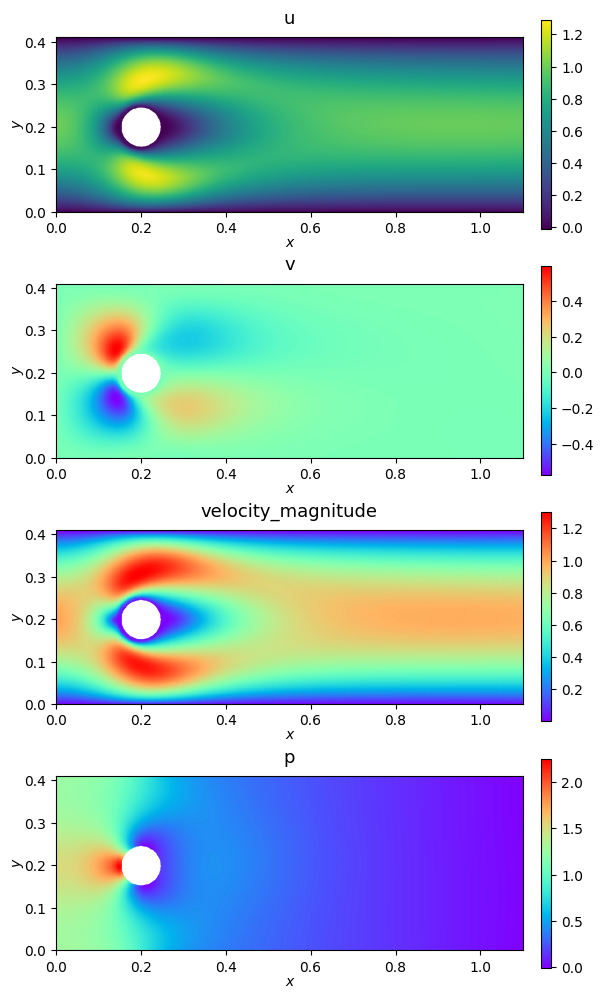

In [53]:
cmap_dict = {
    'u':None,
    'v':'rainbow',
    'velocity_magnitude': 'rainbow',
    'p':'rainbow'
}
colorplot_all = area_visual.plot_data_on_geometry(cmap_dict, s=1)
colorplot_all.savefig('cylinder_flow_steady_all.png')

In [ ]:
# Create visualization object
bound_visual = Visualizer(model2, domain.bound_list[3])
bound_visual.sampling_line(100)
bound_visual.preprocess()

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'total_loss', 'bc_loss', 'pde_loss')


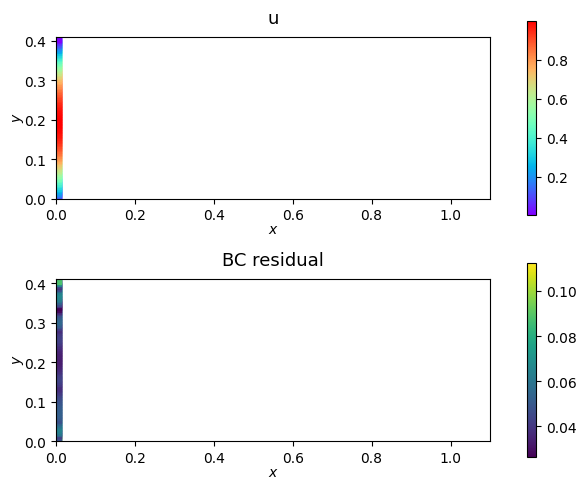

In [41]:
plot = bound_visual.plot_data_on_geometry({'u':'rainbow','BC residual':None}, range_x=[0,1.1], range_y=[0,0.41], s=50)

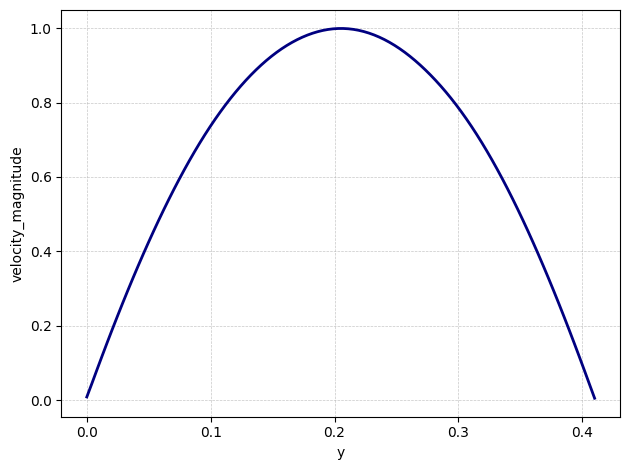

In [42]:
plot = bound_visual.plot_data(['velocity_magnitude'])

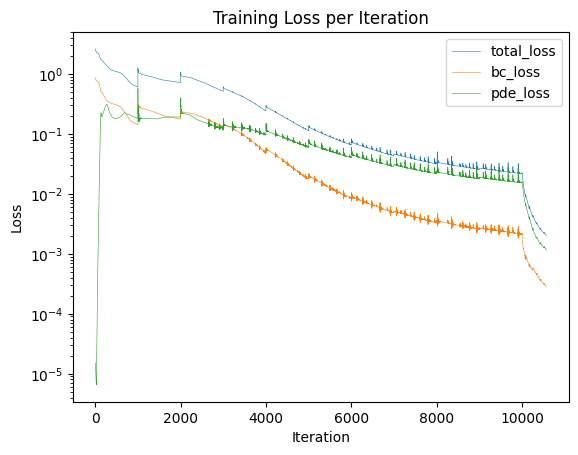

In [43]:
a = bound_visual.plot_loss_evolution(log_scale=True, linewidth=0.4)

In [27]:
import pickle

# Save model with pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model1, f)


In [28]:
# # Load model back
# with open("model.pkl", "rb") as f:
#     model1 = pickle.load(f)

In [29]:
# import numpy as np
# data = np.loadtxt("laminar flow data.txt", delimiter=",", skiprows=1)

NameError: name 'data' is not defined

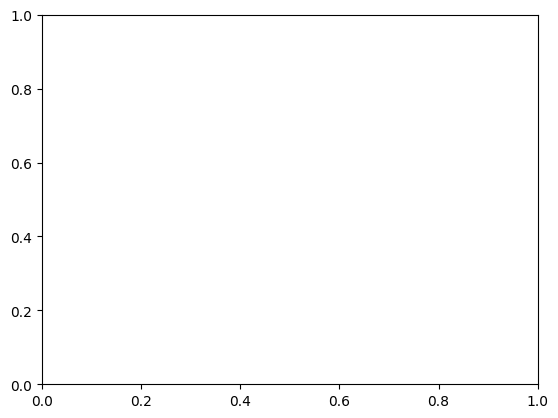

In [30]:
fig, ax = plt.subplots()

X = data[:,1]
Y = data[:,2]
Pressure = data[:,3]
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
Visualizer.colorplot(X, Y, Pressure, ax, s=0.4, cmap='rainbow')
